# Initial Imports

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from nltk.stem import PorterStemmer
from collections import Counter
from tensorflow.keras import Sequential
from tensorflow.keras.layers import (
    Embedding, 
    Conv1D,
    MaxPooling1D,
    Flatten,
    Dense,
    Dropout,
    Input,
    LSTM,
    Bidirectional
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from joblib import dump
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, TFAutoModel
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2

In [5]:
print(tf.config.list_physical_devices('GPU'))

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Default GPU Device: /device:GPU:0


# Data Exploration

In [6]:
data_directory = "data"
raw_data_directory = "raw-data"
model_saves_directory = "model-saves"
therapist_data_path = os.path.join(raw_data_directory, "20200325_counsel_chat.csv")
reddit_train_data_path = os.path.join(raw_data_directory, "dreaddit-train.csv")
reddit_test_data_path = os.path.join(raw_data_directory, "dreaddit-test.csv")

## Council chat data

In [7]:
counsel_chat_data = pd.read_csv(therapist_data_path)
counsel_chat_data.head()

,Unnamed: 0,questionID,questionTitle,questionText,questionLink,topic,therapistInfo,therapistURL,answerText,upvotes,views,split
0,0,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Sherry Katz, LCSWCouples and Family Therapist,...",https://counselchat.com/therapists/sherry-katz...,"If everyone thinks you're worthless, then mayb...",1,2899,train
1,1,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Robin Landwehr, DBH, LPCC, NCCMental Health in...",https://counselchat.com/therapists/robin-landw...,"Hello, and thank you for your question and see...",1,3514,train
2,2,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Lee KingI use an integrative approach to treat...,https://counselchat.com/therapists/lee-king,First thing I'd suggest is getting the sleep y...,0,5,train
3,3,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,"Shauntai Davis-YearginPersonalized, private on...",https://counselchat.com/therapists/shauntai-da...,Therapy is essential for those that are feelin...,0,31,train
4,4,0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,https://counselchat.com/questions/can-i-change...,depression,Jordan WhiteLicensed Social Worker at Oak Root...,https://counselchat.com/therapists/jordan-white,I first want to let you know that you are not ...,0,620,train


In [8]:
counsel_chat_label_counts = counsel_chat_data['topic'].value_counts()
counsel_chat_label_counts

topic
depression                  330
anxiety                     249
counseling-fundamentals     240
intimacy                    205
relationships               174
parenting                   145
family-conflict             116
self-esteem                  83
relationship-dissolution     76
trauma                       66
behavioral-change            51
marriage                     46
lgbtq                        38
anger-management             38
substance-abuse              35
spirituality                 34
professional-ethics          32
workplace-relationships      26
diagnosis                    22
domestic-violence            21
social-relationships         20
grief-and-loss               18
self-harm                    11
sleep-improvement            10
eating-disorders             10
legal-regulatory              8
stress                        7
children-adolescents          6
addiction                     5
human-sexuality               4
military-issues               3
Na

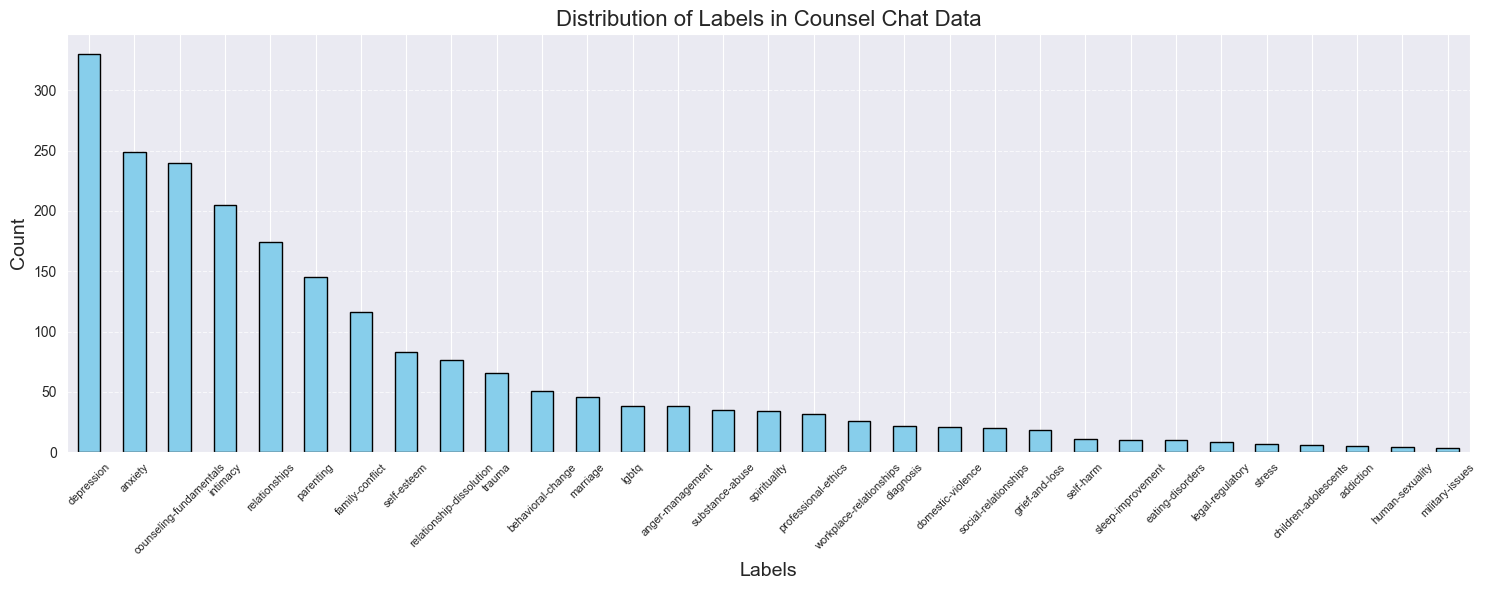

In [9]:
plt.figure(figsize=(15, 6))
counsel_chat_label_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Labels in Counsel Chat Data', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

## Reddit Data

In [10]:
reddit_train_data = pd.read_csv(reddit_train_data_path, encoding='latin1')
reddit_test_data = pd.read_csv(reddit_test_data_path, encoding='latin1')

In [11]:
reddit_total_data = pd.concat([reddit_train_data, reddit_test_data], ignore_index=True)
reddit_total_data.head()

,subreddit,post_id,sentence_range,text,id,label,confidence,social_timestamp,social_karma,syntax_ari,...,lex_dal_min_pleasantness,lex_dal_min_activation,lex_dal_min_imagery,lex_dal_avg_activation,lex_dal_avg_imagery,lex_dal_avg_pleasantness,social_upvote_ratio,social_num_comments,syntax_fk_grade,sentiment
0,ptsd,8601tu,"(15, 20)","He said he had not felt that way before, sugge...",33181,1,0.8,1521614353,5,1.806818,...,1.000,1.1250,1.0,1.77000,1.52211,1.89556,0.86,1,3.253573,-0.002742
1,assistance,8lbrx9,"(0, 5)","Hey there r/assistance, Not sure if this is th...",2606,0,1.0,1527009817,4,9.429737,...,1.125,1.0000,1.0,1.69586,1.62045,1.88919,0.65,2,8.828316,0.292857
2,ptsd,9ch1zh,"(15, 20)",My mom then hit me with the newspaper and it s...,38816,1,0.8,1535935605,2,7.769821,...,1.000,1.1429,1.0,1.83088,1.58108,1.85828,0.67,0,7.841667,0.011894
3,relationships,7rorpp,"[5, 10]","until i met my new boyfriend, he is amazing, h...",239,1,0.6,1516429555,0,2.667798,...,1.000,1.1250,1.0,1.75356,1.52114,1.98848,0.50,5,4.104027,0.141671
4,survivorsofabuse,9p2gbc,"[0, 5]",October is Domestic Violence Awareness Month a...,1421,1,0.8,1539809005,24,7.554238,...,1.000,1.1250,1.0,1.77644,1.64872,1.81456,1.00,1,7.910952,-0.204167


In [12]:
reddit_total_label_counts = reddit_total_data['subreddit'].value_counts()
reddit_total_label_counts

subreddit
ptsd                711
relationships       694
anxiety             650
domesticviolence    388
assistance          355
survivorsofabuse    315
homeless            220
almosthomeless       99
stress               78
food_pantry          43
Name: count, dtype: int64

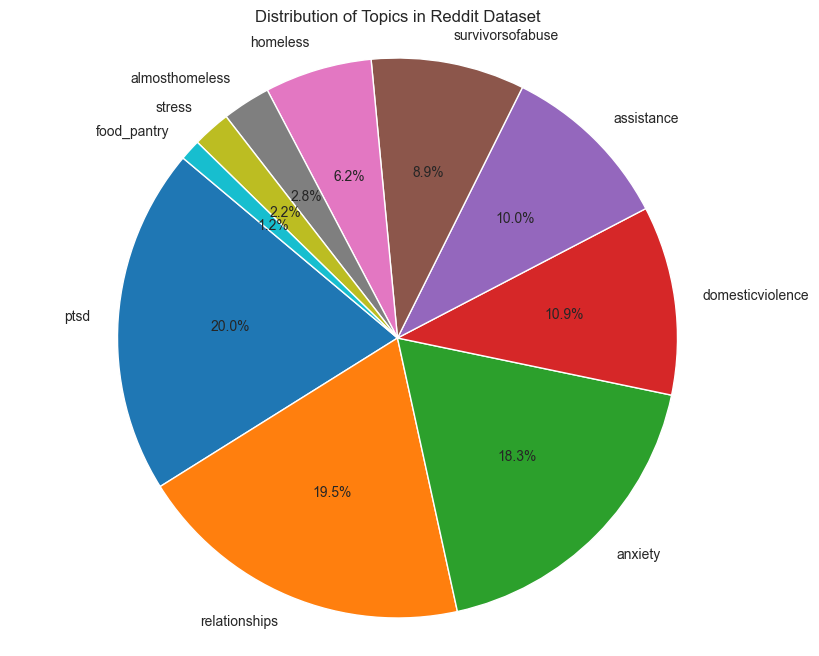

In [13]:
plt.figure(figsize=(10, 8))
plt.pie(
    reddit_total_label_counts,
    labels=reddit_total_label_counts.index,
    autopct='%1.1f%%',
    startangle=140
)
plt.title('Distribution of Topics in Reddit Dataset')
plt.axis('equal') 
plt.show()

# Explore Various Features

## Counsel data combined text - word & char counts, most common words, pos tagging

In [14]:
counsel_chat_data = counsel_chat_data[['questionTitle', 'questionText', 'topic', 'answerText']]
counsel_chat_data['combinedText'] = counsel_chat_data['questionText'] + ' ' + counsel_chat_data['answerText']

counsel_chat_data.head()

,questionTitle,questionText,topic,answerText,combinedText
0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",I'm going through some things with my feelings...
1,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"Hello, and thank you for your question and see...",I'm going through some things with my feelings...
2,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,First thing I'd suggest is getting the sleep y...,I'm going through some things with my feelings...
3,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,Therapy is essential for those that are feelin...,I'm going through some things with my feelings...
4,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,I first want to let you know that you are not ...,I'm going through some things with my feelings...


In [15]:
counsel_chat_data['word_count'] = counsel_chat_data['combinedText'].apply(lambda x: len(str(x).split()))
counsel_chat_data['char_count'] = counsel_chat_data['combinedText'].apply(lambda x: len(str(x)))

counsel_chat_data.head()

,questionTitle,questionText,topic,answerText,combinedText,word_count,char_count
0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",I'm going through some things with my feelings...,223,1290
1,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"Hello, and thank you for your question and see...",I'm going through some things with my feelings...,427,2411
2,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,First thing I'd suggest is getting the sleep y...,I'm going through some things with my feelings...,120,628
3,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,Therapy is essential for those that are feelin...,I'm going through some things with my feelings...,197,1173
4,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,I first want to let you know that you are not ...,I'm going through some things with my feelings...,123,666


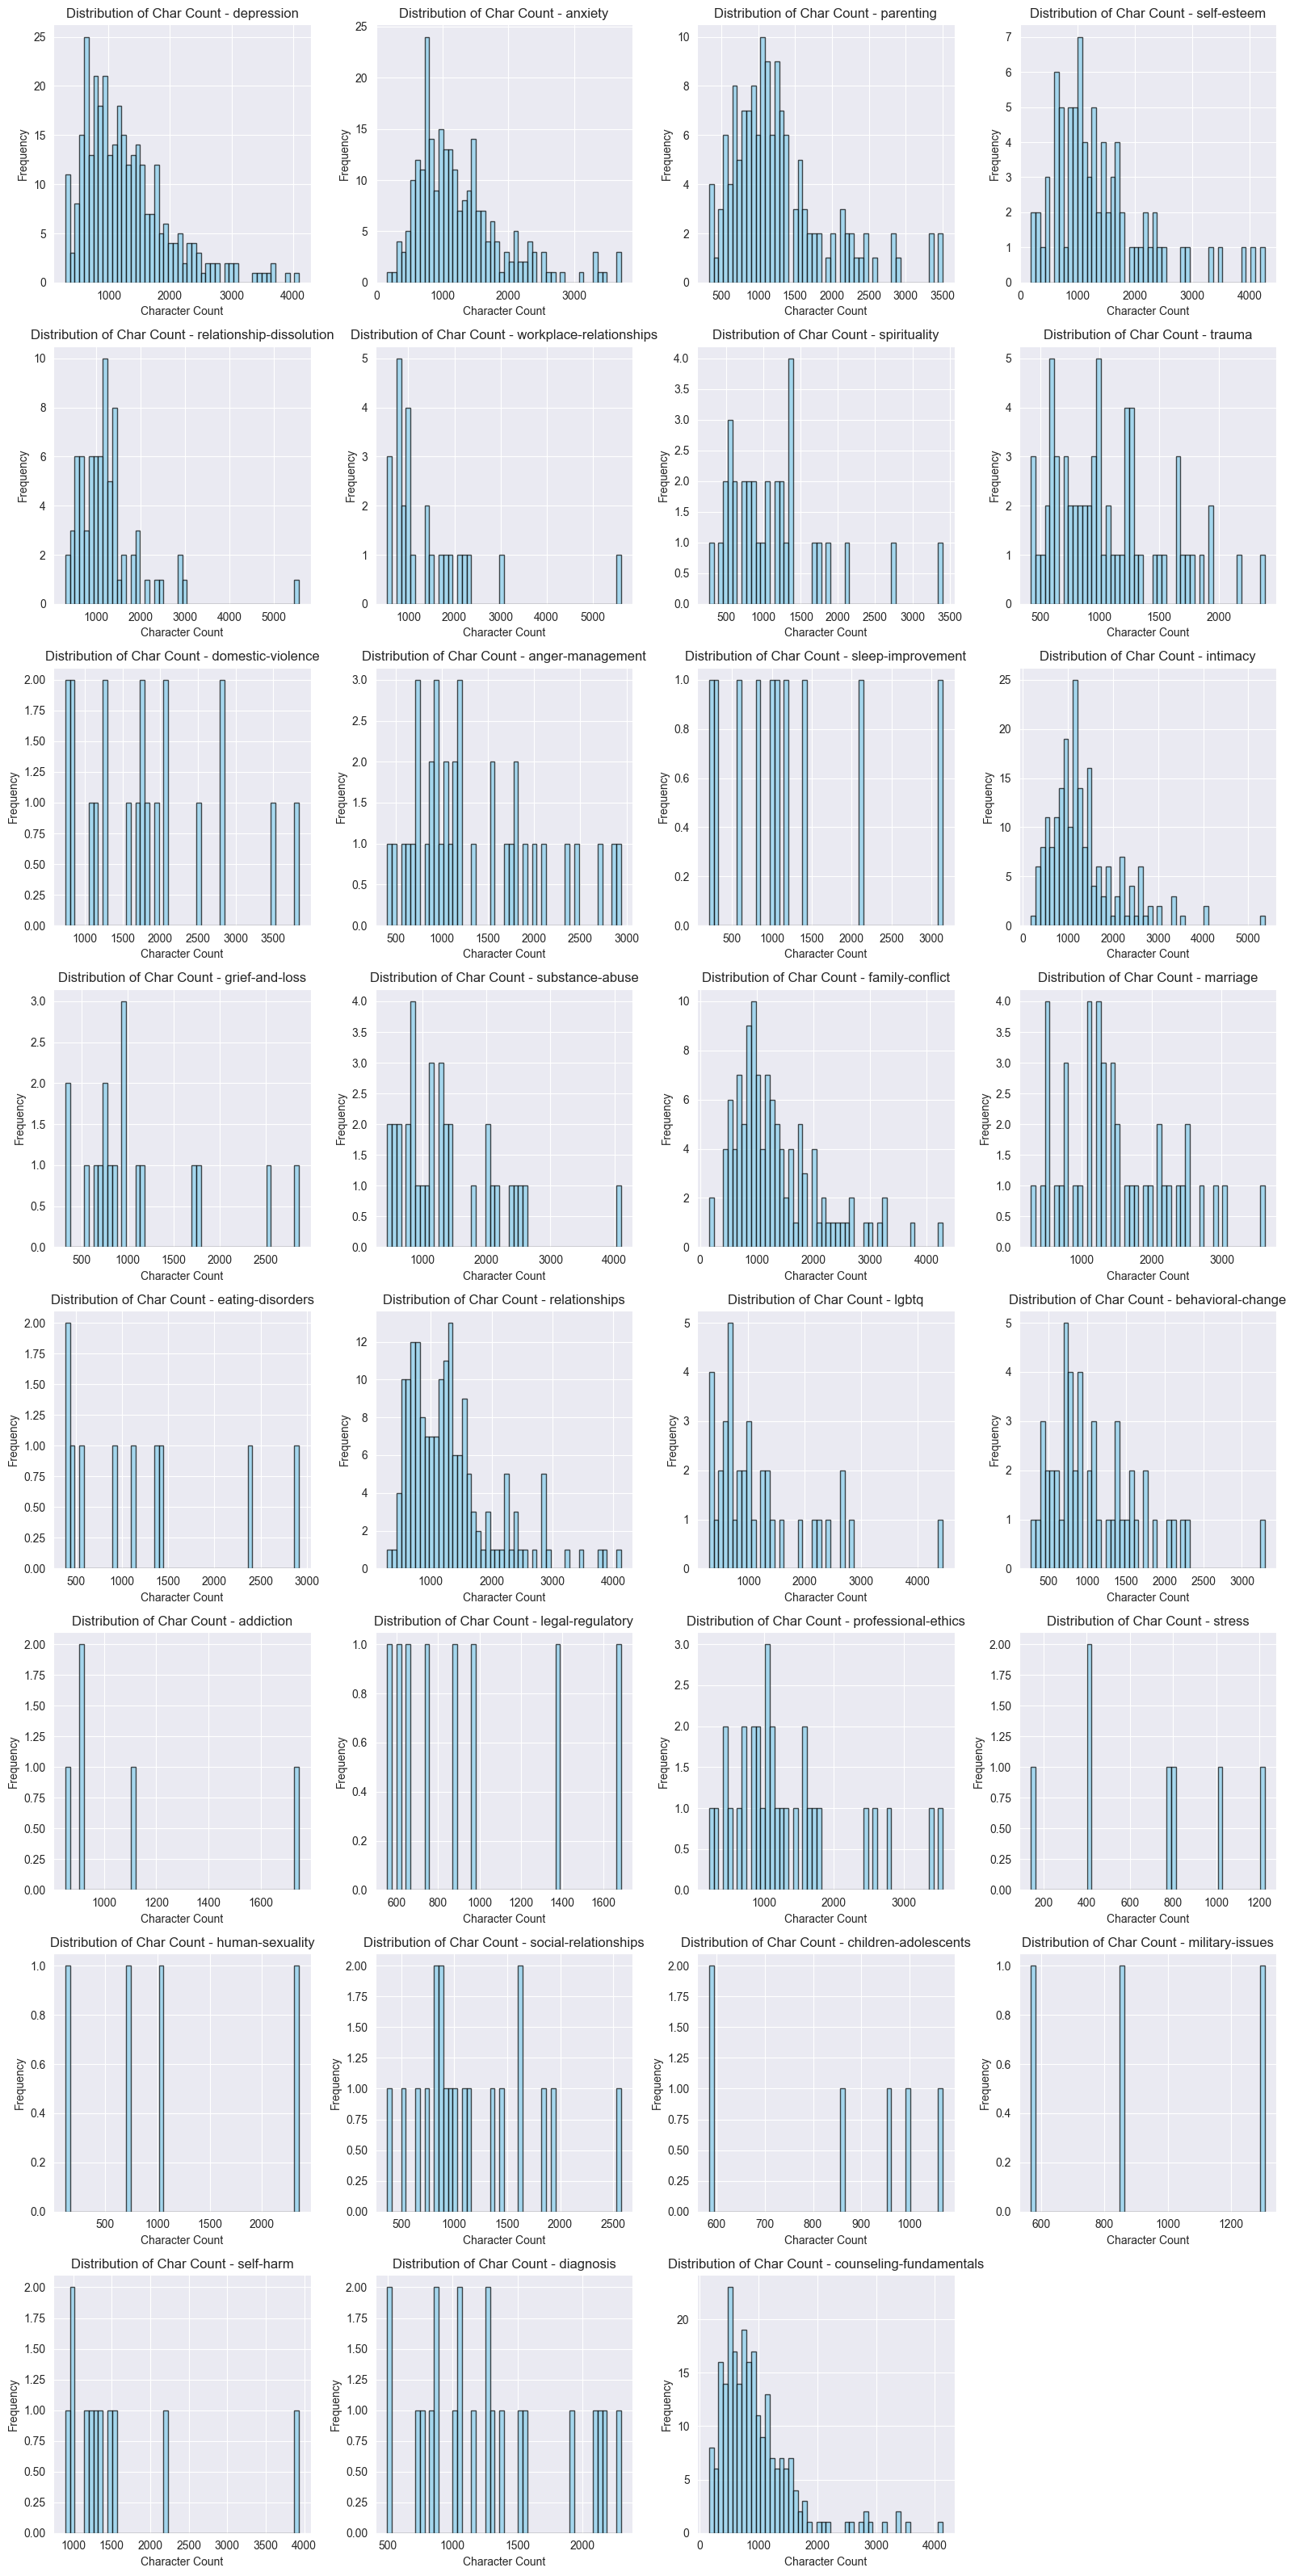

In [16]:
topics = counsel_chat_data['topic'].unique()
n_cols = 4 
n_rows = (len(topics) // n_cols) + 1  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    topic_data = counsel_chat_data[counsel_chat_data['topic'] == topic]
    ax.hist(topic_data['char_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of Char Count - {topic}')
    ax.set_xlabel('Character Count')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

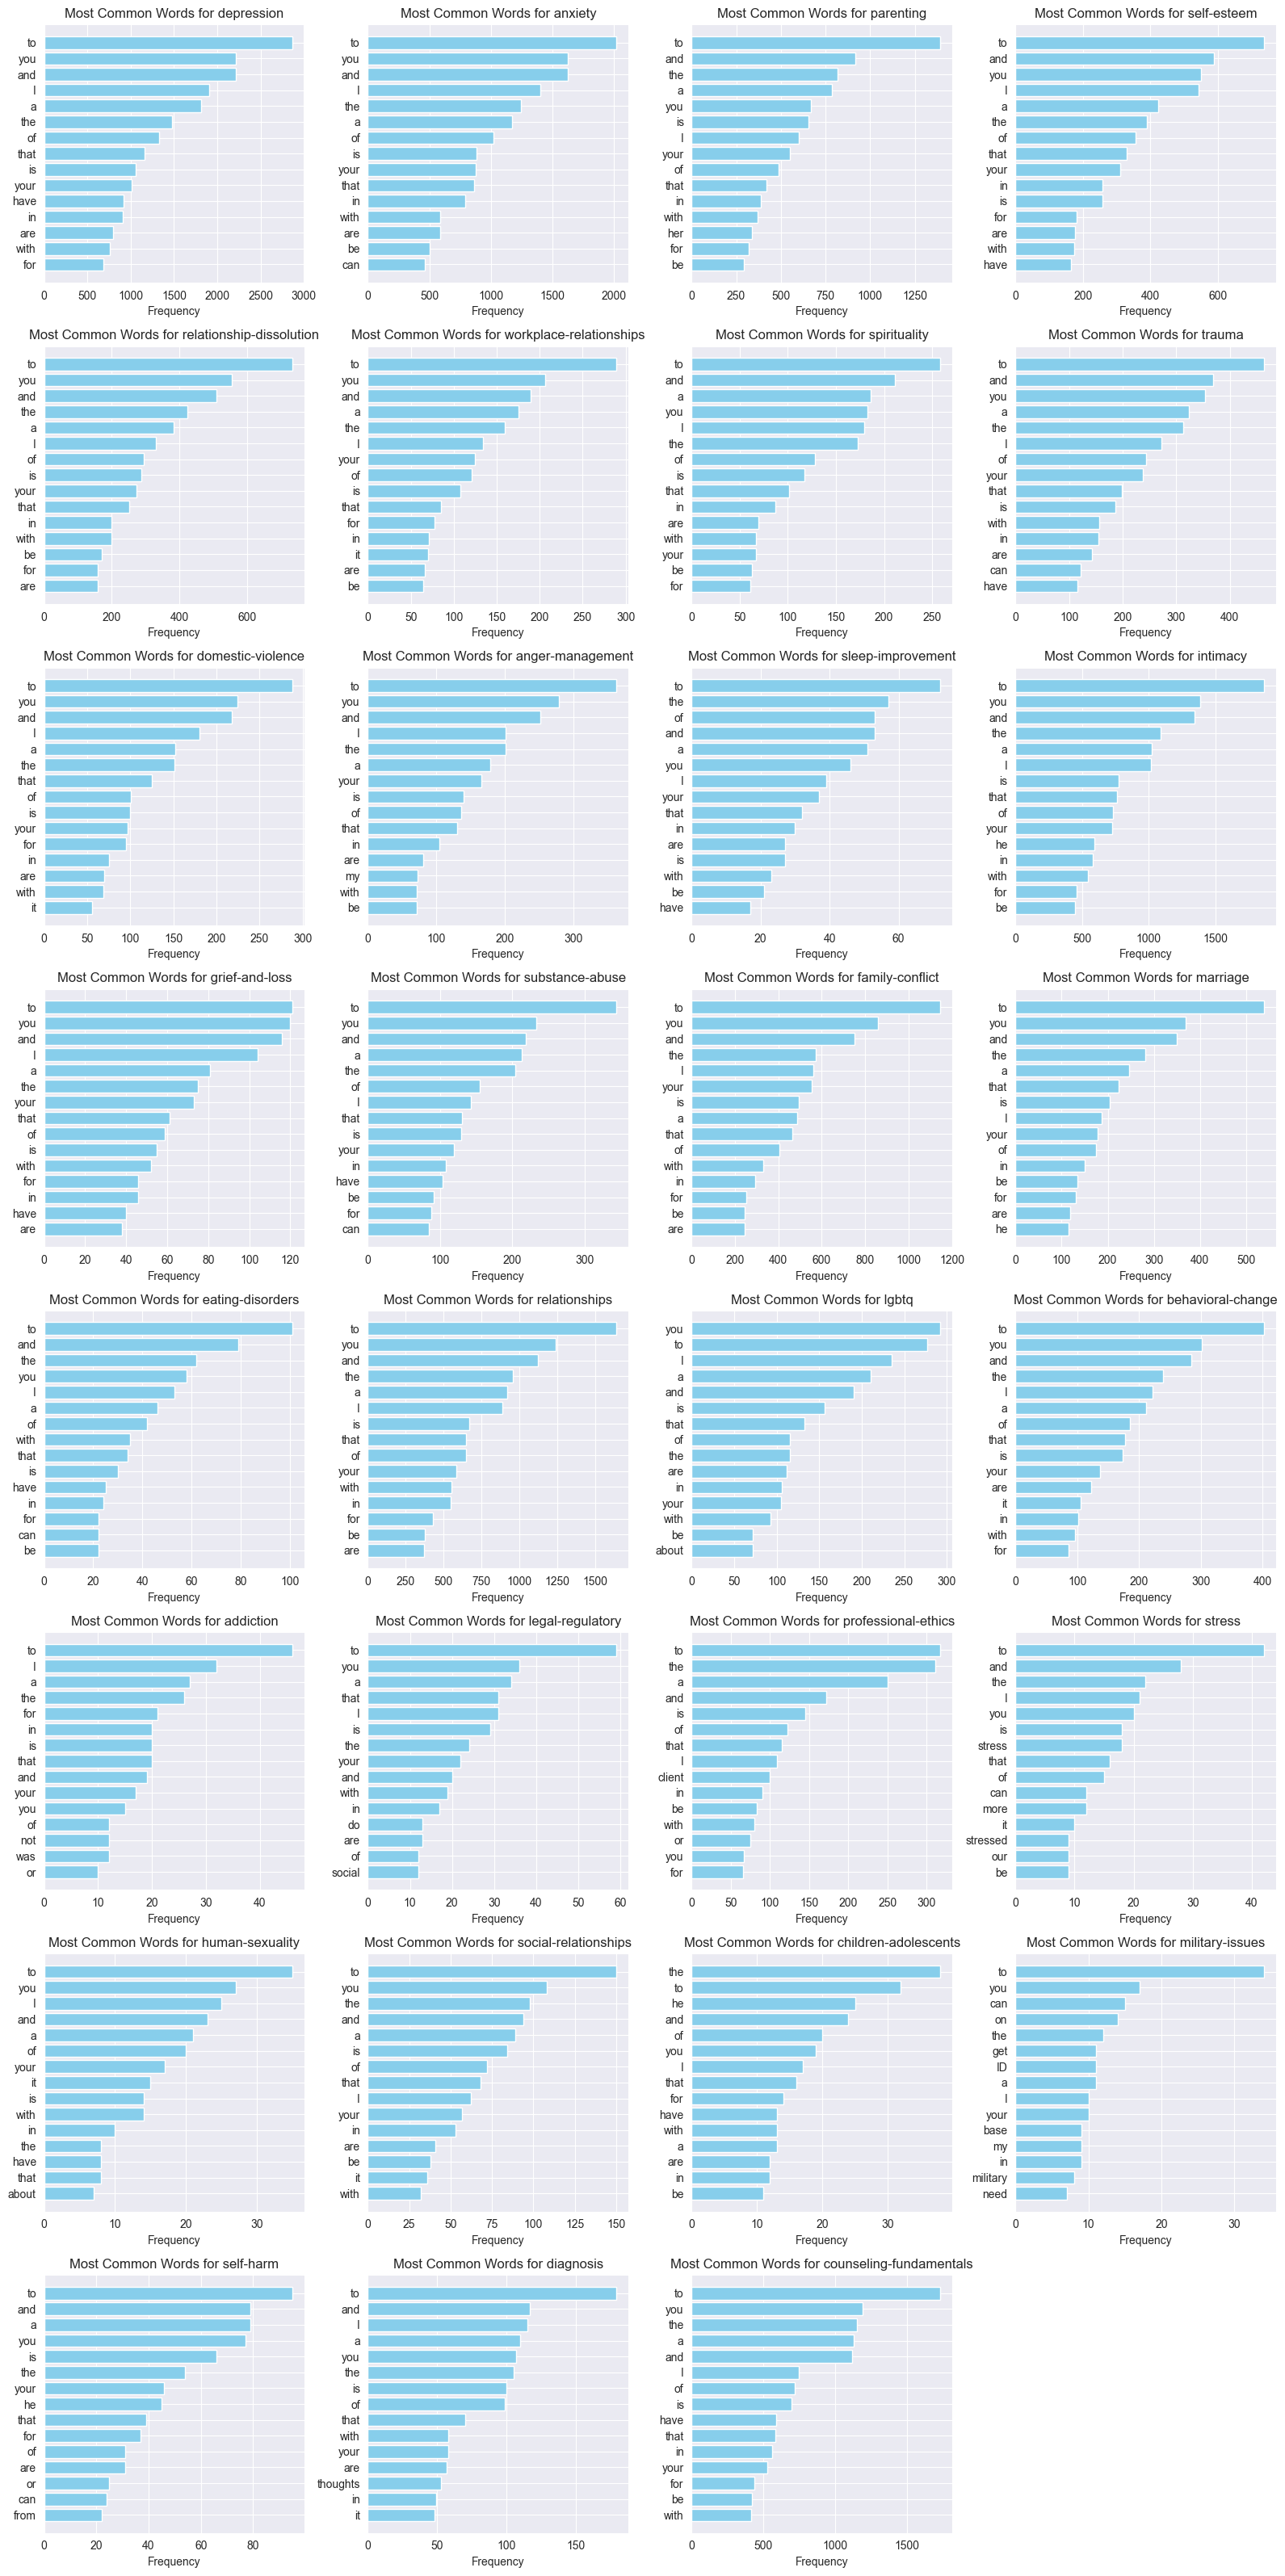

In [17]:
n_cols = 4  
n_rows = (len(topics) // n_cols) + 1 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    topic_words = counsel_chat_data[counsel_chat_data['topic'] == topic]['combinedText'].str.split().sum()
    
    topic_word_counts = Counter(topic_words)
    topic_top_words = topic_word_counts.most_common(15)
    words, counts = zip(*topic_top_words)
    
    ax.barh(words, counts, color='skyblue')
    ax.set_title(f'Most Common Words for {topic}')
    ax.invert_yaxis()  
    ax.set_xlabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [18]:
def pos_tag_text(text):
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens) 
    return [tag for word, tag in pos_tags]

In [19]:
counsel_chat_data['pos_tags'] = counsel_chat_data['combinedText'].apply(pos_tag_text)
counsel_chat_data.head()

,questionTitle,questionText,topic,answerText,combinedText,word_count,char_count,pos_tags
0,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"If everyone thinks you're worthless, then mayb...",I'm going through some things with my feelings...,223,1290,"[PRP, VBP, VBG, IN, DT, NNS, IN, PRP$, NNS, CC..."
1,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,"Hello, and thank you for your question and see...",I'm going through some things with my feelings...,427,2411,"[PRP, VBP, VBG, IN, DT, NNS, IN, PRP$, NNS, CC..."
2,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,First thing I'd suggest is getting the sleep y...,I'm going through some things with my feelings...,120,628,"[PRP, VBP, VBG, IN, DT, NNS, IN, PRP$, NNS, CC..."
3,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,Therapy is essential for those that are feelin...,I'm going through some things with my feelings...,197,1173,"[PRP, VBP, VBG, IN, DT, NNS, IN, PRP$, NNS, CC..."
4,Can I change my feeling of being worthless to ...,I'm going through some things with my feelings...,depression,I first want to let you know that you are not ...,I'm going through some things with my feelings...,123,666,"[PRP, VBP, VBG, IN, DT, NNS, IN, PRP$, NNS, CC..."


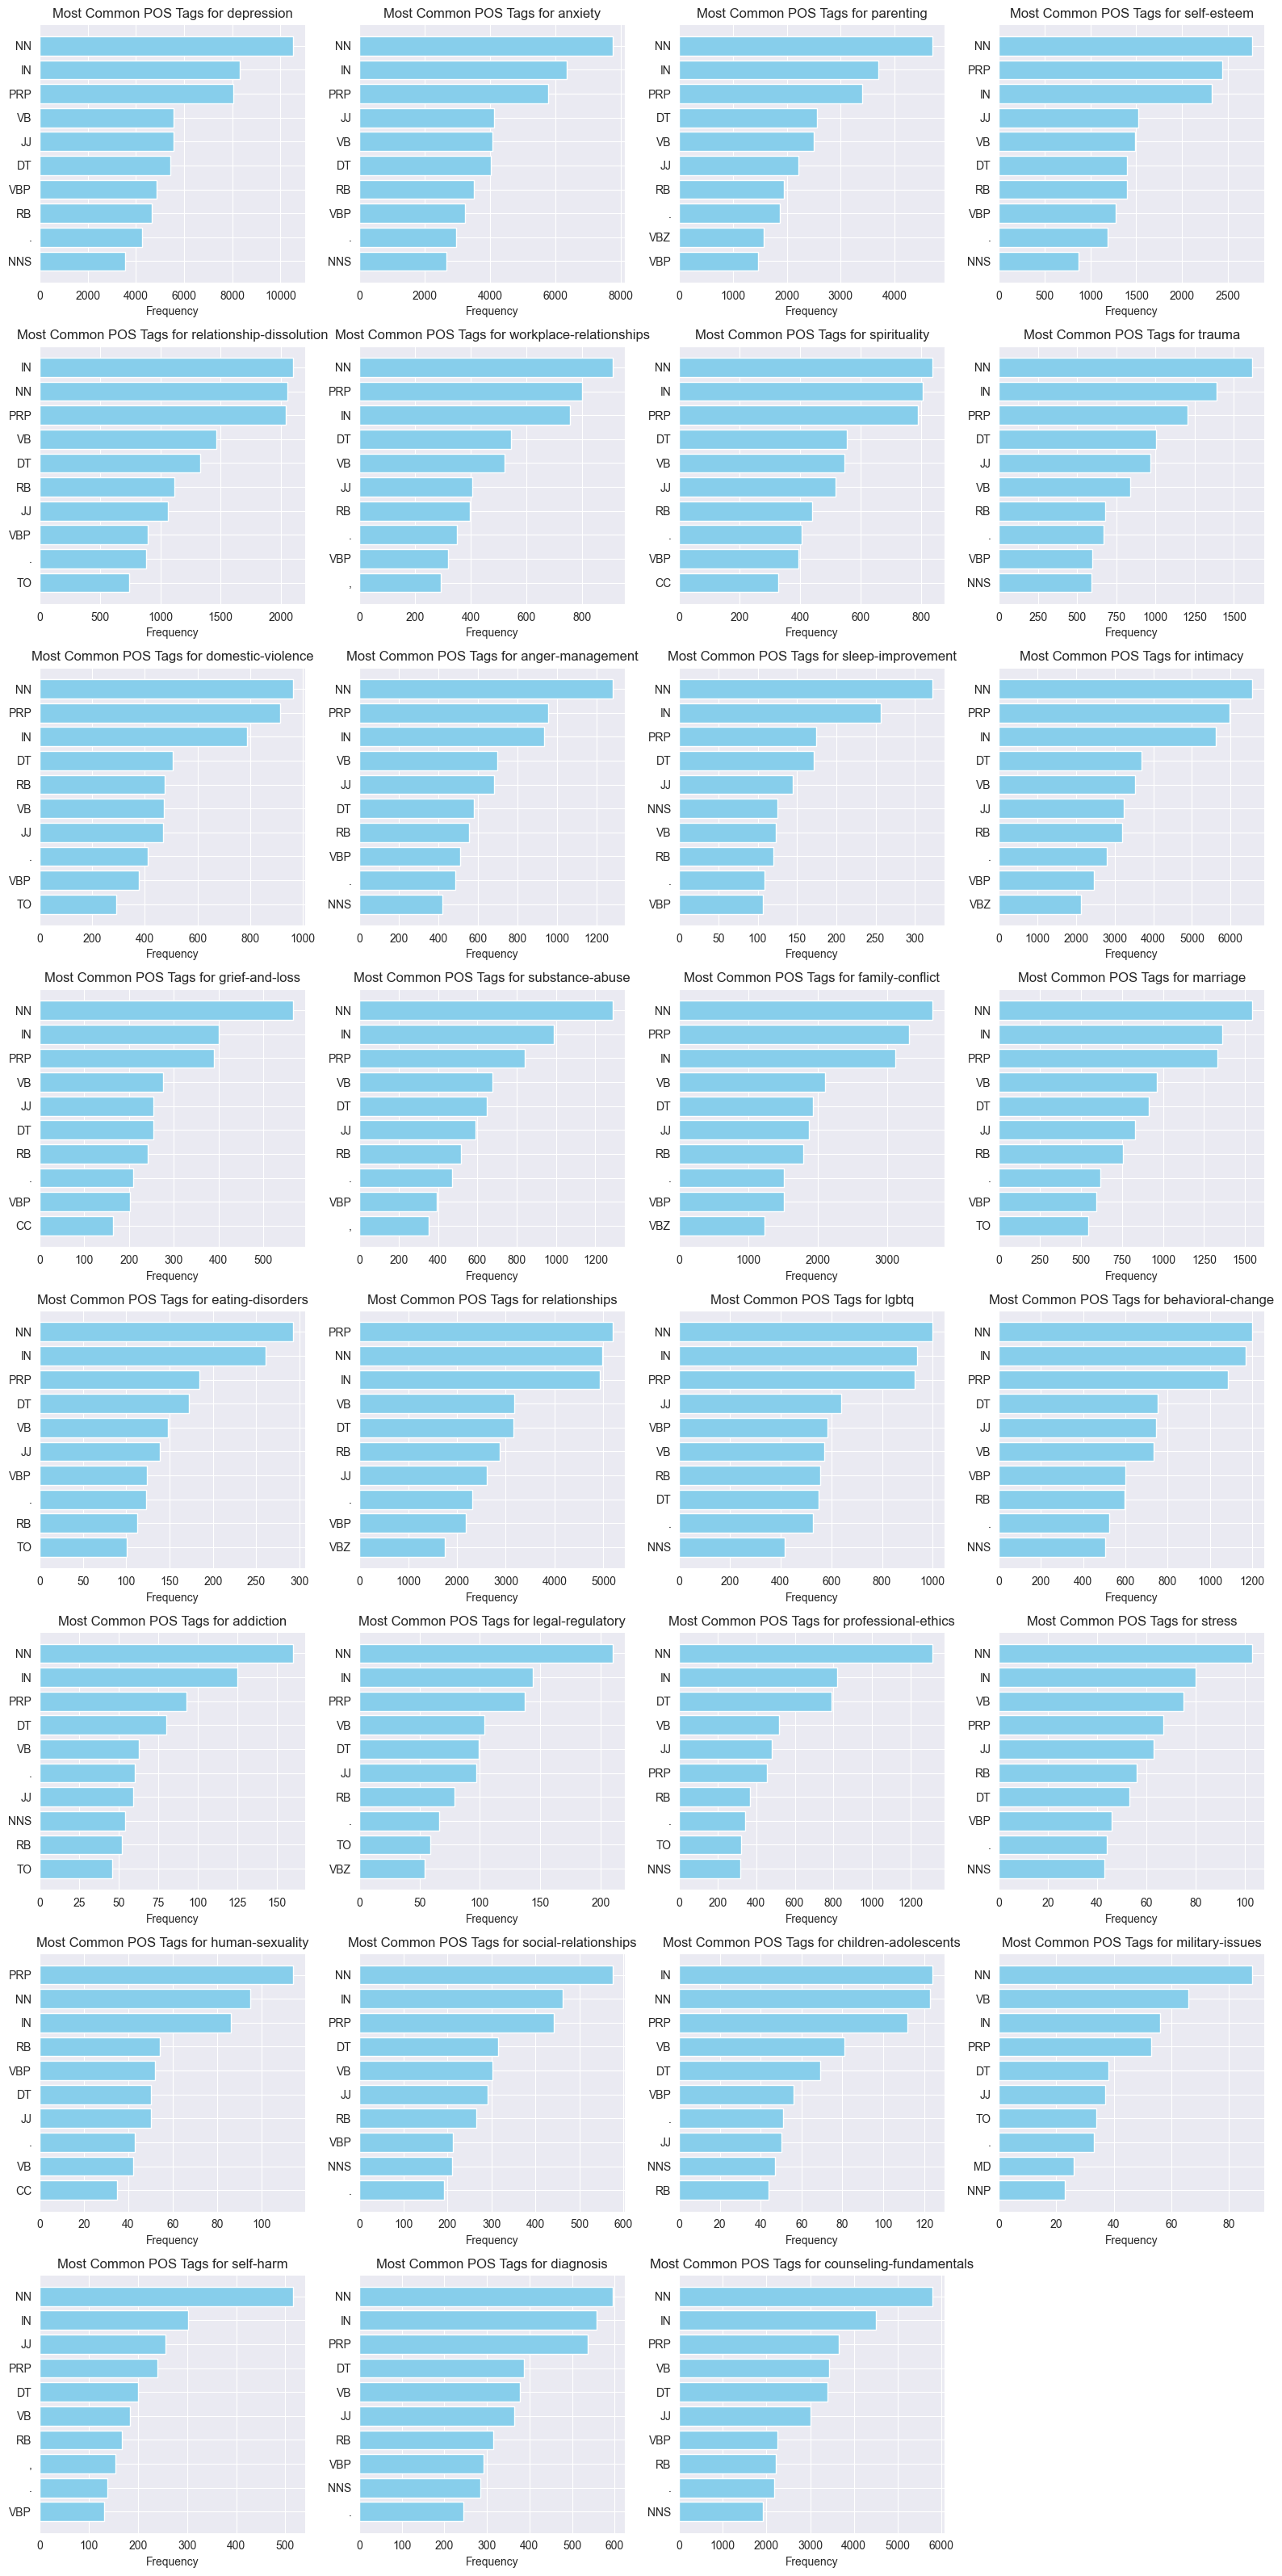

In [20]:
n_cols = 4
n_rows = (len(topics) // n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(topics):
    ax = axes[i]
    topic_pos_tags = counsel_chat_data[counsel_chat_data['topic'] == topic]['pos_tags'].sum()
    topic_pos_tag_counts = Counter(topic_pos_tags)
    topic_top_pos_tags = topic_pos_tag_counts.most_common(10)
    pos_tags, counts = zip(*topic_top_pos_tags)
    
    ax.barh(pos_tags, counts, color='skyblue')
    ax.set_title(f'Most Common POS Tags for {topic}')
    ax.invert_yaxis()  
    ax.set_xlabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Reddit data combined text - word & char counts, most common words, pos tagging

In [21]:
reddit_total_data = reddit_total_data[["subreddit", "text", "label", "sentiment", "social_karma", "post_id"]]
reddit_total_data['text'] = reddit_total_data['text'].fillna("").astype(str)
reddit_total_data.head()

,subreddit,text,label,sentiment,social_karma,post_id
0,ptsd,"He said he had not felt that way before, sugge...",1,-0.002742,5,8601tu
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,0.292857,4,8lbrx9
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.011894,2,9ch1zh
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.141671,0,7rorpp
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,-0.204167,24,9p2gbc


In [22]:
reddit_total_data['word_count'] = reddit_total_data['text'].apply(lambda x: len(str(x).split()))
reddit_total_data['char_count'] = reddit_total_data['text'].apply(lambda x: len(str(x)))

reddit_total_data.head()

,subreddit,text,label,sentiment,social_karma,post_id,word_count,char_count
0,ptsd,"He said he had not felt that way before, sugge...",1,-0.002742,5,8601tu,113,571
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,0.292857,4,8lbrx9,108,588
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.011894,2,9ch1zh,166,847
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.141671,0,7rorpp,273,1277
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,-0.204167,24,9p2gbc,89,532


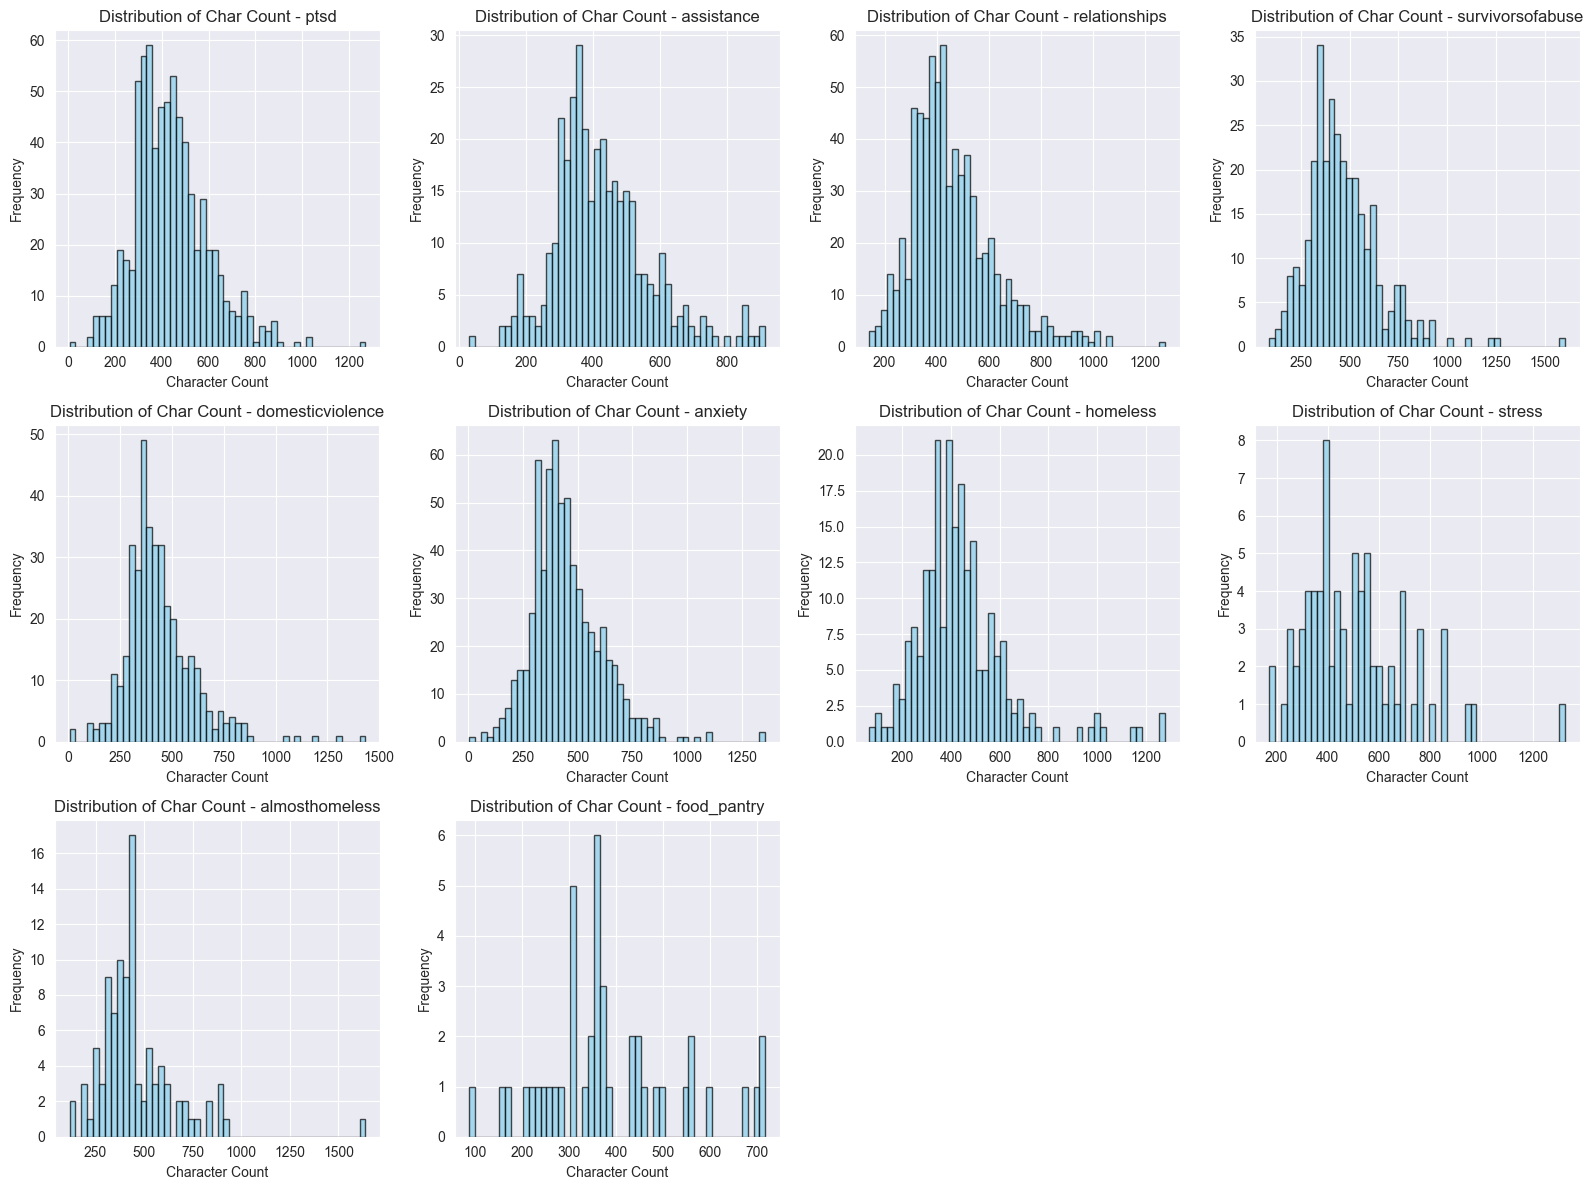

In [23]:
reddit_topics = reddit_total_data['subreddit'].unique()
n_cols = 4 
n_rows = (len(reddit_topics) // n_cols) + 1  

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(reddit_topics):
    ax = axes[i]
    topic_data = reddit_total_data[reddit_total_data['subreddit'] == topic]
    ax.hist(topic_data['char_count'], bins=50, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'Distribution of Char Count - {topic}')
    ax.set_xlabel('Character Count')
    ax.set_ylabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

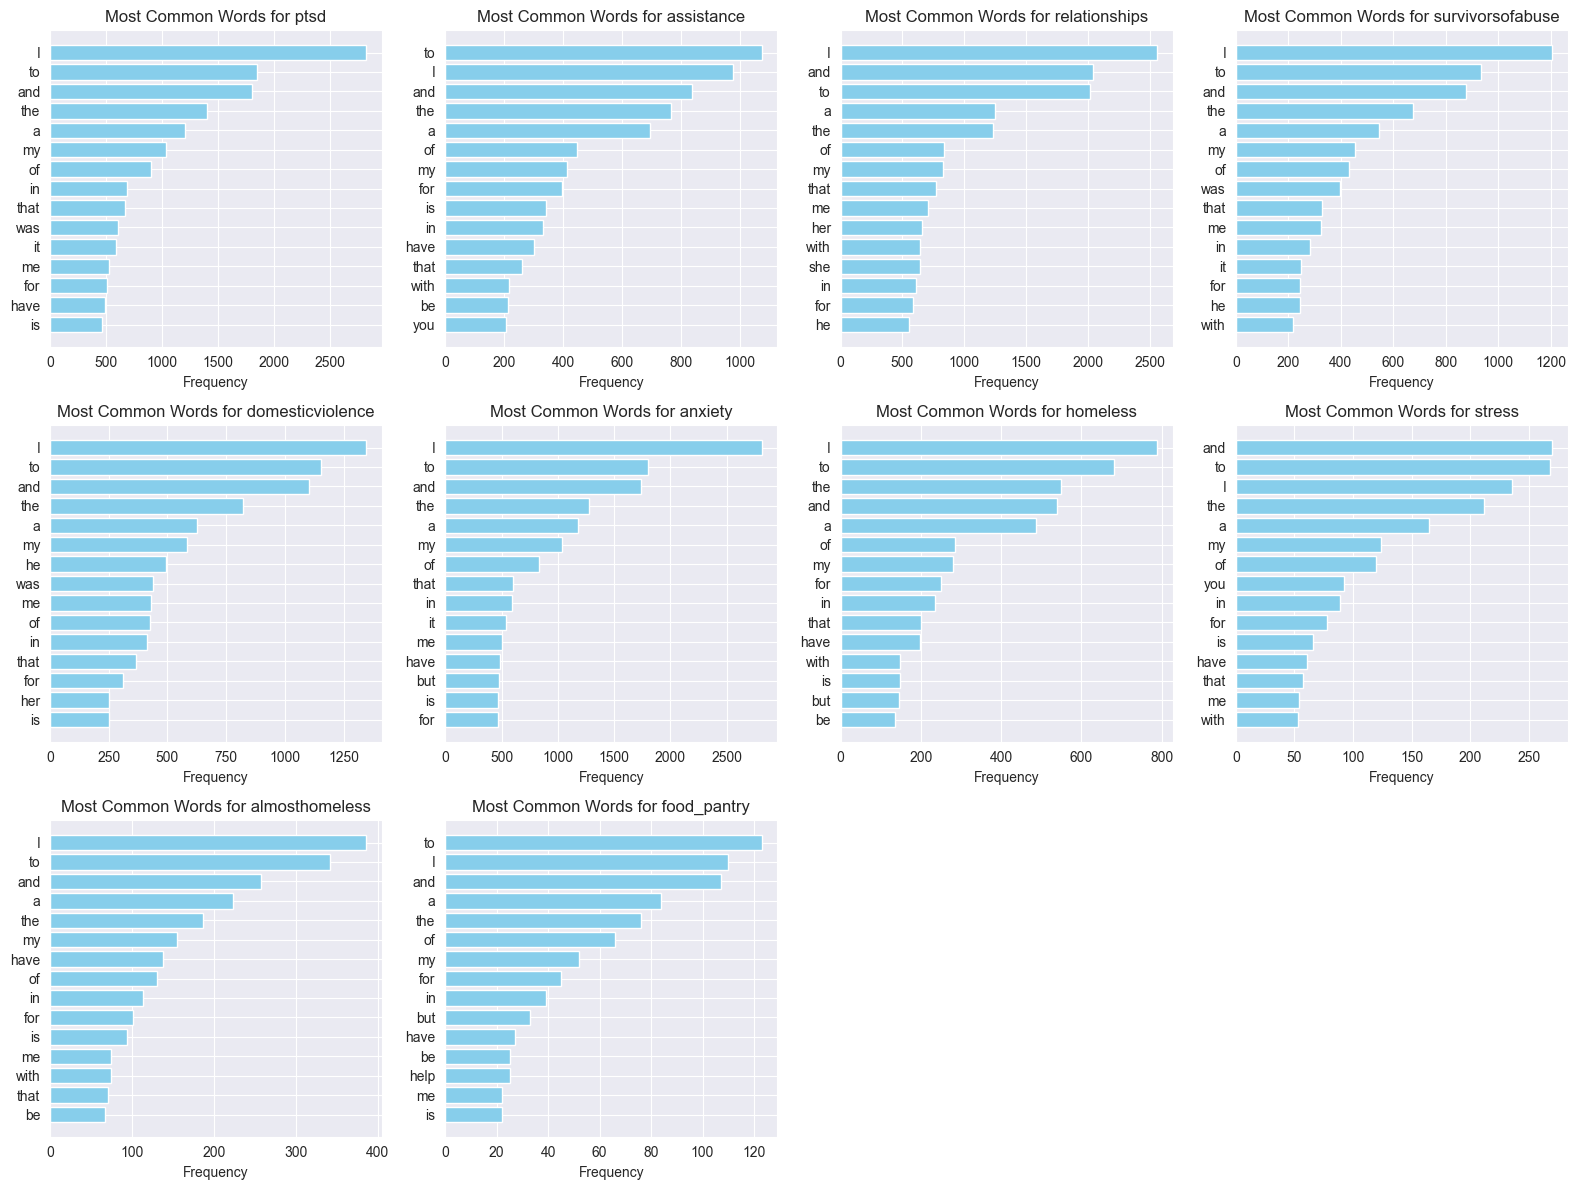

In [24]:
n_cols = 4  
n_rows = (len(reddit_topics) // n_cols) + 1 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(reddit_topics):
    ax = axes[i]
    topic_words = reddit_total_data[reddit_total_data['subreddit'] == topic]['text'].str.split().sum()
    
    topic_word_counts = Counter(topic_words)
    topic_top_words = topic_word_counts.most_common(15)
    words, counts = zip(*topic_top_words)
    
    ax.barh(words, counts, color='skyblue')
    ax.set_title(f'Most Common Words for {topic}')
    ax.invert_yaxis()  
    ax.set_xlabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [25]:
reddit_total_data['pos_tags'] = reddit_total_data['text'].apply(pos_tag_text)
reddit_total_data.head()

,subreddit,text,label,sentiment,social_karma,post_id,word_count,char_count,pos_tags
0,ptsd,"He said he had not felt that way before, sugge...",1,-0.002742,5,8601tu,113,571,"[PRP, VBD, PRP, VBD, RB, VBN, IN, NN, IN, ,, V..."
1,assistance,"Hey there r/assistance, Not sure if this is th...",0,0.292857,4,8lbrx9,108,588,"[NNP, EX, NN, ,, RB, JJ, IN, DT, VBZ, DT, JJ, ..."
2,ptsd,My mom then hit me with the newspaper and it s...,1,0.011894,2,9ch1zh,166,847,"[PRP$, NN, RB, VBD, PRP, IN, DT, NN, CC, PRP, ..."
3,relationships,"until i met my new boyfriend, he is amazing, h...",1,0.141671,0,7rorpp,273,1277,"[IN, JJ, VBD, PRP$, JJ, NN, ,, PRP, VBZ, JJ, ,..."
4,survivorsofabuse,October is Domestic Violence Awareness Month a...,1,-0.204167,24,9p2gbc,89,532,"[NNP, VBZ, JJ, NNP, NNP, NNP, CC, PRP, VBP, DT..."


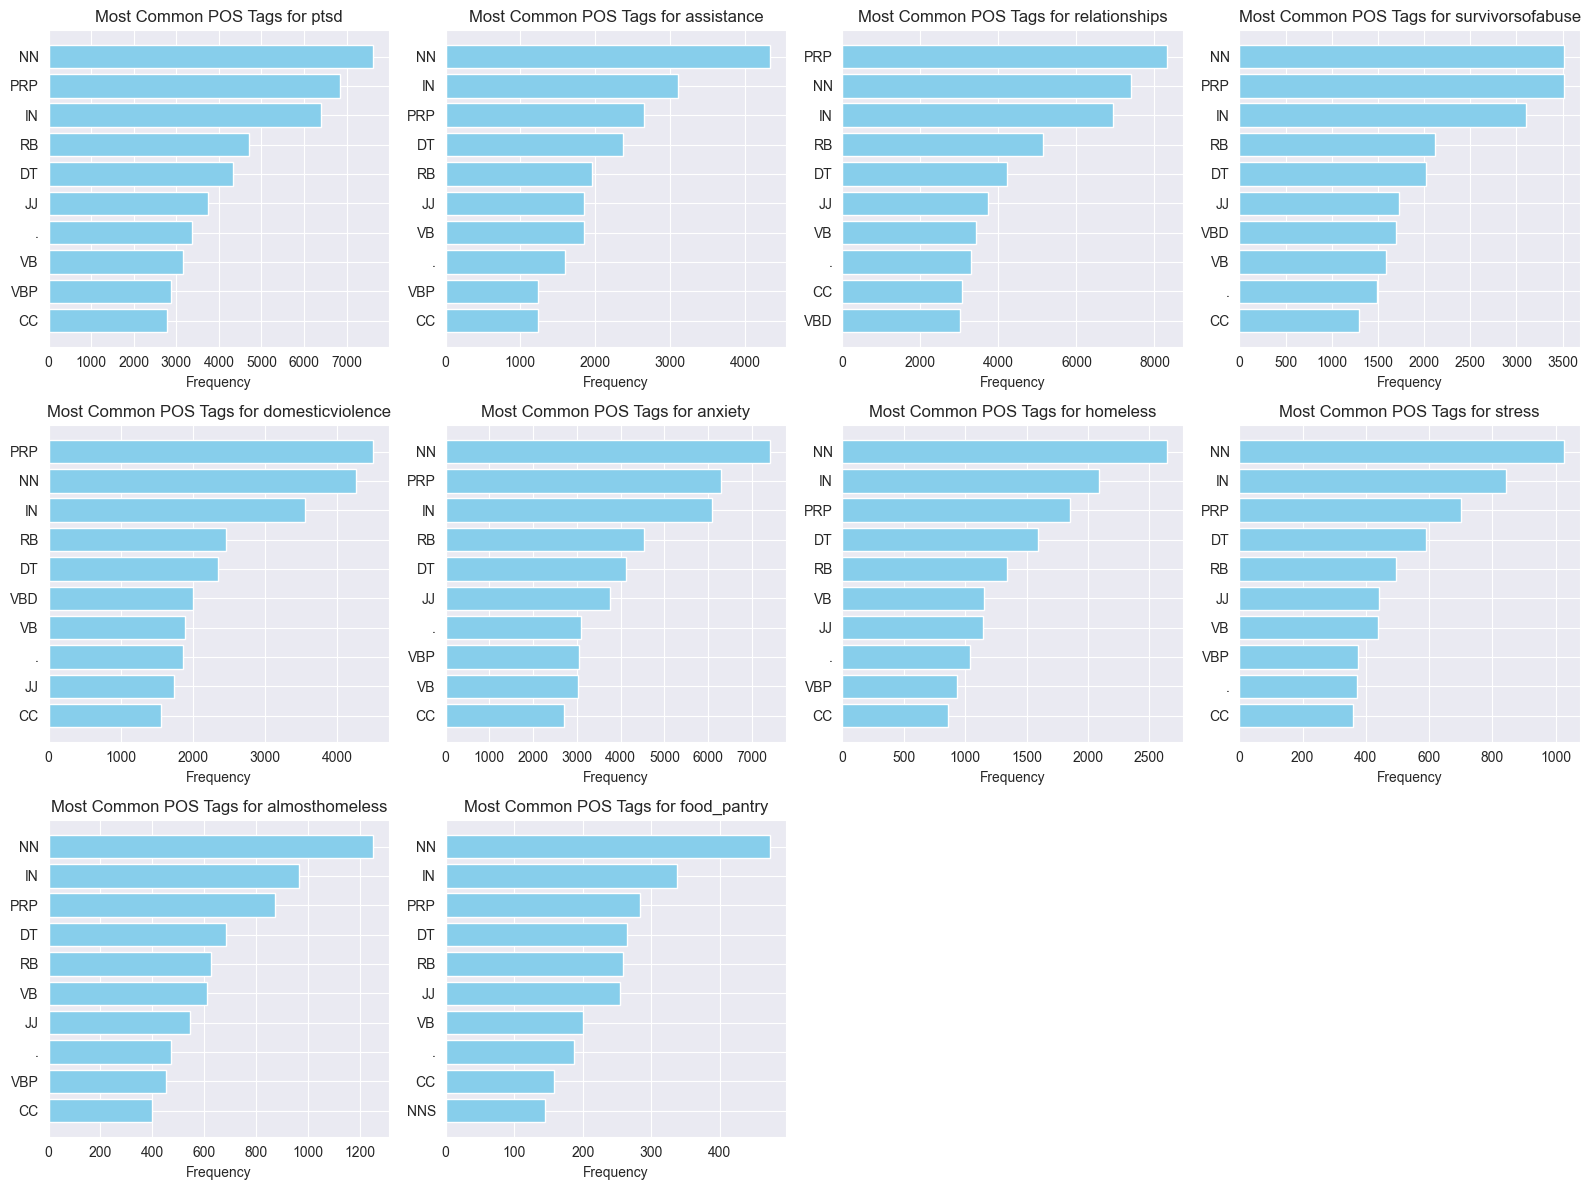

In [26]:
n_cols = 4
n_rows = (len(reddit_topics) // n_cols) + 1

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

for i, topic in enumerate(reddit_topics):
    ax = axes[i]
    topic_pos_tags = reddit_total_data[reddit_total_data['subreddit'] == topic]['pos_tags'].sum()
    topic_pos_tag_counts = Counter(topic_pos_tags)
    topic_top_pos_tags = topic_pos_tag_counts.most_common(10)
    pos_tags, counts = zip(*topic_top_pos_tags)
    
    ax.barh(pos_tags, counts, color='skyblue')
    ax.set_title(f'Most Common POS Tags for {topic}')
    ax.invert_yaxis()  
    ax.set_xlabel('Frequency')

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

# Preprocess data

## Lower text, remove urls, remove punctuation, remove stopwords, stemming

In [27]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def preprocess_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    tokens = [stemmer.stem(word) for word in tokens]
    
    text = ' '.join(tokens)
    return text

In [28]:
counsel_chat_data['combinedText'] = counsel_chat_data['combinedText'].apply(preprocess_text)
counsel_chat_data['combinedText']

0       im go thing feel bare sleep noth think im wort...
1       im go thing feel bare sleep noth think im wort...
2       im go thing feel bare sleep noth think im wort...
3       im go thing feel bare sleep noth think im wort...
4       im go thing feel bare sleep noth think im wort...
                              ...                        
2124    first meet client process counselor facilit pr...
2125    first meet client process counselor facilit co...
2126    first meet client process counselor facilit me...
2127    first meet client process counselor facilit go...
2128    first meet client process counselor facilit gr...
Name: combinedText, Length: 2129, dtype: object

In [29]:
reddit_total_data['text'] = reddit_total_data['text'].apply(preprocess_text)
reddit_total_data['text']

0       said felt way sugget go rest trigger ahead you...
1       hey rassist sure right place post goe im curre...
2       mom hit newspap shock would know dont like pla...
3       met new boyfriend amaz kind sweet good student...
4       octob domest violenc awar month domest violenc...
                              ...                        
3548    horribl vivid nightmar everi night sometim the...
3549    also cant think without get angri jealou talk ...
3550    furthermor told got realli seriou anxieti depr...
3551    here link amazon wish list two item url link d...
3552    keep us protect alreadi told unwelcom person l...
Name: text, Length: 3553, dtype: object

## Split data for processing (3 cases: counsel, reddit, combined)

In [30]:
label_encoder = LabelEncoder()

In [190]:
label_counts = Counter(counsel_chat_data['topic'])
top_10_labels = [label for label, count in label_counts.most_common(10)]

filtered_features = counsel_chat_data[counsel_chat_data['topic'].isin(top_10_labels)]['combinedText']
filtered_labels = counsel_chat_data[counsel_chat_data['topic'].isin(top_10_labels)]['topic']

counsel_training_data, counsel_testing_data, counsel_training_labels, counsel_testing_labels = train_test_split(
    filtered_features, filtered_labels, test_size=0.2, random_state=42
)

print("Counsel Chat Data Split:")
print(f"Train Features: {counsel_training_data.shape}, Test Features: {counsel_testing_data.shape}")

Counsel Chat Data Split:
Train Features: (1347,), Test Features: (337,)


In [46]:
counsel_data_features = counsel_chat_data['combinedText']
counsel_data_labels = counsel_chat_data['topic']
counsel_training_data, counsel_testing_data, counsel_training_labels, counsel_testing_labels = train_test_split(
    counsel_data_features, counsel_data_labels, test_size=0.2, random_state=42
)

counsel_training_labels_encoded = np.array(label_encoder.fit_transform(counsel_training_labels))
counsel_testing_labels_encoded = np.array(label_encoder.transform(counsel_testing_labels))

print("Counsel Chat Data Split:")
print(f"Train Features: {counsel_training_data.shape}, Test Features: {counsel_testing_data.shape}")

Counsel Chat Data Split:
Train Features: (1703,), Test Features: (426,)


In [29]:
counsel_training_data.shape, counsel_training_labels.shape, counsel_testing_data.shape, counsel_testing_labels.shape, counsel_training_labels_encoded.shape, counsel_testing_labels_encoded.shape

((1703,), (1703,), (426,), (426,), (1703,), (426,))

In [30]:
reddit_data_features = reddit_total_data['text']
reddit_data_labels = reddit_total_data['subreddit']
reddit_training_data, reddit_testing_data, reddit_training_labels, reddit_testing_labels = train_test_split(
    reddit_data_features, reddit_data_labels, test_size=0.2, random_state=42
)

reddit_training_labels_encoded = np.array(label_encoder.fit_transform(reddit_training_labels))
reddit_testing_labels_encoded = np.array(label_encoder.transform(reddit_testing_labels))

print("Reddit Data Split:")
print(f"Train Features: {reddit_training_data.shape}, Test Features: {reddit_testing_data.shape}")

Reddit Data Split:
Train Features: (2842,), Test Features: (711,)


In [33]:
counsel_combined = counsel_chat_data[['topic', 'questionText', 'answerText']].copy()
counsel_combined['text'] = counsel_chat_data['combinedText'] 
counsel_combined = counsel_combined[['topic', 'text']]
counsel_combined.columns = ['label', 'text']

reddit_combined = reddit_total_data[['subreddit', 'text']].copy()
reddit_combined.columns = ['label', 'text']

combined_data = pd.concat([counsel_combined, reddit_combined], ignore_index=True)
combined_training_data, combined_testing_data, combined_training_labels, combined_testing_labels = train_test_split(
    combined_data['text'], combined_data['label'], test_size=0.2, random_state=42
)

combined_training_labels_encoded = np.array(label_encoder.fit_transform(combined_training_labels))
combined_testing_labels_encoded = np.array(label_encoder.transform(combined_testing_labels))

print("Combined Data Split:")
print(f"Train Features: {combined_training_data.shape}, Test Features: {combined_testing_data.shape}")

Combined Data Split:
Train Features: (4545,), Test Features: (1137,)


In [34]:
label_counts = Counter(combined_data['label'])
top_10_labels = [label for label, count in label_counts.most_common(10)]

filtered_features = combined_data[combined_data['label'].isin(top_10_labels)]['text']
filtered_labels = combined_data[combined_data['label'].isin(top_10_labels)]['label']

combined_training_data_10features, combined_testing_data_10features, combined_training_labels_10features, combined_testing_labels_10features = train_test_split(
    filtered_features, filtered_labels, test_size=0.2, random_state=42
)

combined_training_labels_10features_encoded = np.array(label_encoder.fit_transform(combined_training_labels_10features))
combined_testing_labels_10features_encoded = np.array(label_encoder.transform(combined_testing_labels_10features))

print("Combined Data, but just with 10 features Split:")
print(f"Train Features: {combined_training_data_10features.shape}, Test Features: {combined_testing_data_10features.shape}")

Combined Data, but just with 10 features Split:
Train Features: (3624,), Test Features: (907,)


In [35]:
top_10_labels

['anxiety',
 'relationships',
 'ptsd',
 'domesticviolence',
 'assistance',
 'depression',
 'survivorsofabuse',
 'counseling-fundamentals',
 'homeless',
 'intimacy']

# Classification models

## CNN

In [36]:
cnn_training_data, cnn_testing_data, cnn_training_labels, cnn_testing_labels = combined_training_data_10features, combined_testing_data_10features, combined_training_labels_10features_encoded, combined_testing_labels_10features_encoded

In [37]:
max_sequence_length = 2500

tokenizer = Tokenizer()
tokenizer.fit_on_texts(cnn_training_data)

cnn_training_sequences = tokenizer.texts_to_sequences(cnn_training_data)
cnn_testing_sequences = tokenizer.texts_to_sequences(cnn_testing_data)

cnn_training_sequences_padded = pad_sequences(cnn_training_sequences, maxlen=max_sequence_length)
cnn_testing_sequences_padded = pad_sequences(cnn_testing_sequences, maxlen=max_sequence_length)

vocabulary_size = len(tokenizer.word_index) + 1
vocabulary_size

12076

In [38]:
class_weights = compute_class_weight(
    'balanced', 
    classes=np.unique(cnn_training_labels), 
    y=cnn_training_labels
)

class_weight_dictionary = dict(zip(np.unique(cnn_training_labels), class_weights))
class_weight_dictionary

{0: 0.5047353760445682,
 1: 1.2284745762711864,
 2: 2.013333333333333,
 3: 1.4324110671936758,
 4: 1.1219814241486068,
 5: 2.059090909090909,
 6: 2.157142857142857,
 7: 0.6436944937833037,
 8: 0.509704641350211,
 9: 1.5291139240506328}

In [39]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=15000,
    decay_rate=0.9,
    staircase=True
)

types_count = len(class_weight_dictionary)

cnn_model = Sequential([
    Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=128, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=256, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(32, activation="relu"),
    Dropout(0.5),
    Dense(types_count, activation="softmax"),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cnn_model_history = cnn_model.fit(
  cnn_training_sequences_padded, cnn_training_labels,
  epochs = 50,
  batch_size=32,
  validation_data=(cnn_testing_sequences_padded, cnn_testing_labels)
)

Epoch 1/50
114/114 [==============================] - 10s 63ms/step - loss: 2.2525 - accuracy: 0.1628 - val_loss: 2.2088 - val_accuracy: 0.1731
Epoch 2/50
114/114 [==============================] - 6s 53ms/step - loss: 2.2011 - accuracy: 0.1995 - val_loss: 2.1906 - val_accuracy: 0.1996
Epoch 3/50
114/114 [==============================] - 6s 52ms/step - loss: 2.1811 - accuracy: 0.1879 - val_loss: 2.1797 - val_accuracy: 0.1731
Epoch 4/50
114/114 [==============================] - 6s 52ms/step - loss: 2.1756 - accuracy: 0.1868 - val_loss: 2.1812 - val_accuracy: 0.1996
Epoch 5/50
114/114 [==============================] - 6s 52ms/step - loss: 2.1687 - accuracy: 0.1865 - val_loss: 2.1803 - val_accuracy: 0.1996
Epoch 6/50
114/114 [==============================] - 6s 52ms/step - loss: 2.1600 - accuracy: 0.1978 - val_loss: 2.1770 - val_accuracy: 0.1996
Epoch 7/50
114/114 [==============================] - 6s 52ms/step - loss: 2.1496 - accuracy: 0.2028 - val_loss: 2.1303 - val_accuracy: 0.187

KeyboardInterrupt: 

In [40]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=15000,
    decay_rate=0.9,
    staircase=True
)

types_count = len(class_weight_dictionary)

cnn_model = Sequential([
    Embedding(input_dim=vocabulary_size, output_dim=128, input_length=max_sequence_length),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    MaxPooling1D(pool_size=2),
    LSTM(256),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(types_count, activation="softmax"),
])

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

cnn_model_history = cnn_model.fit(
  cnn_training_sequences_padded, cnn_training_labels,
  epochs = 20,
  batch_size=32,
  validation_data=(cnn_testing_sequences_padded, cnn_testing_labels),
)

Epoch 1/20
114/114 [==============================] - 25s 194ms/step - loss: 2.1134 - accuracy: 0.2070 - val_loss: 1.9097 - val_accuracy: 0.2503
Epoch 2/20
114/114 [==============================] - 20s 179ms/step - loss: 1.7386 - accuracy: 0.3195 - val_loss: 1.7858 - val_accuracy: 0.2856
Epoch 3/20
114/114 [==============================] - 22s 189ms/step - loss: 1.5841 - accuracy: 0.3899 - val_loss: 1.8053 - val_accuracy: 0.3451
Epoch 4/20
114/114 [==============================] - 22s 191ms/step - loss: 1.2718 - accuracy: 0.5246 - val_loss: 1.7509 - val_accuracy: 0.3738
Epoch 5/20
114/114 [==============================] - 22s 195ms/step - loss: 0.9180 - accuracy: 0.6692 - val_loss: 1.8790 - val_accuracy: 0.4399
Epoch 6/20
114/114 [==============================] - 22s 193ms/step - loss: 0.6715 - accuracy: 0.7655 - val_loss: 2.0776 - val_accuracy: 0.4388
Epoch 7/20
114/114 [==============================] - 22s 193ms/step - loss: 0.5226 - accuracy: 0.8300 - val_loss: 2.3157 - val_ac

In [41]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2500, 128)         1545728   
                                                                 
 conv1d_6 (Conv1D)           (None, 2496, 64)          41024     
                                                                 
 max_pooling1d_6 (MaxPooling  (None, 1248, 64)         0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 256)               328704    
                                                                 
 dense_3 (Dense)             (None, 64)                16448     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                      

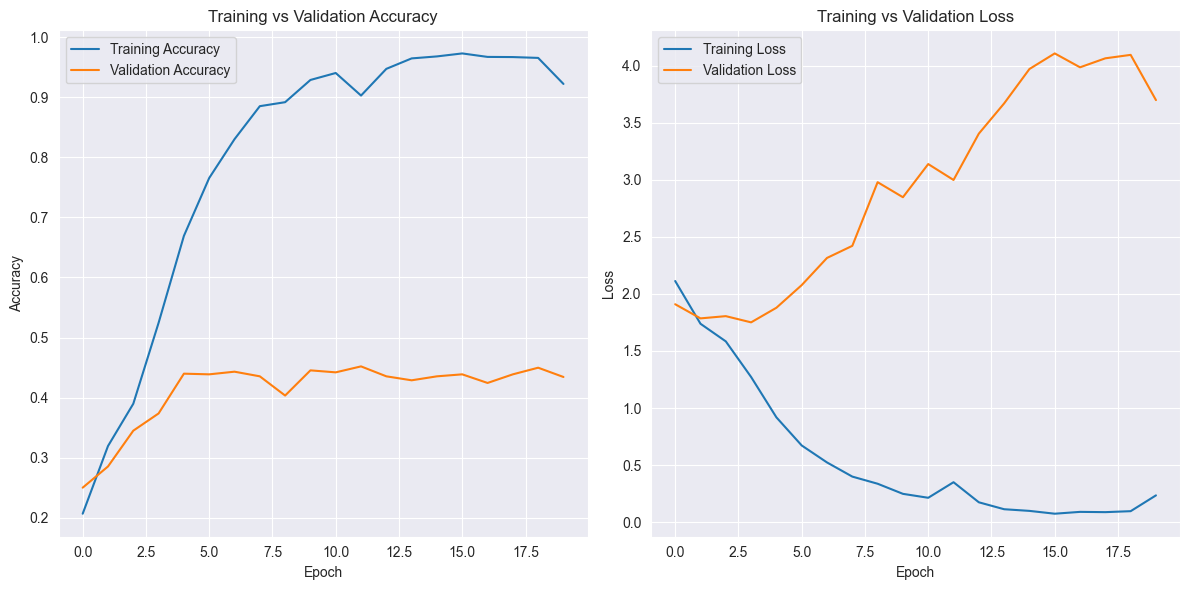

In [42]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(cnn_model_history.history['accuracy'], label='Training Accuracy')
plt.plot(cnn_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_model_history.history['loss'], label='Training Loss')
plt.plot(cnn_model_history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

29/29 [==============================] - 2s 68ms/step


<Figure size 1500x1500 with 0 Axes>

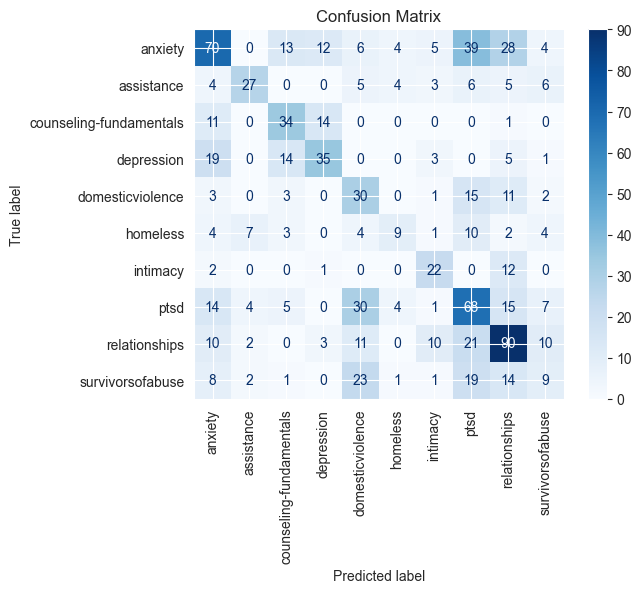

In [43]:
predictions = cnn_model.predict(cnn_testing_sequences_padded)
predicted_labels = predictions.argmax(axis=1)

report = classification_report(cnn_testing_labels, predicted_labels, target_names=label_encoder.classes_, output_dict=True)

conf_matrix = confusion_matrix(cnn_testing_labels, predicted_labels)

# Step 3: Plot the confusion matrix with a larger figure
plt.figure(figsize=(15, 15))  # Increase figure size to fit all classes
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')

plt.title("Confusion Matrix")
plt.show()

In [44]:
cnn_model.save(os.path.join(model_saves_directory, 'cnn_mental_health_types_classification_model.h5'))

## TF-IDF + Logistic Regression/SVM/Random Forest

In [45]:
tfidf = TfidfVectorizer(max_features=5000)
combined_training_data_tfidf = tfidf.fit_transform(combined_training_data)
combined_testing_data_tfidf = tfidf.transform(combined_testing_data)

dump(tfidf, os.path.join(model_saves_directory, 'tfidf_vectorizer.joblib'))

['model-saves\\tfidf_vectorizer.joblib']

In [46]:
tfidf = TfidfVectorizer(max_features=5000)
combined_training_data_10features_tfidf = tfidf.fit_transform(combined_training_data_10features)
combined_testing_data_10features_tfidf = tfidf.transform(combined_testing_data_10features)

dump(tfidf, os.path.join(model_saves_directory, 'tfidf_vectorizer.joblib'))

['model-saves\\tfidf_vectorizer.joblib']

In [47]:
logistic_parameters = {
    'C': [10, 15, 30],
    'solver': ['liblinear'],
    'max_iter': [10, 20, 30]
}

svm_parameters= {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

random_forest_parameters = {
    'n_estimators': [300, 400, 500],
    'max_depth': [None,],
    'min_samples_split': [4, 5, 6]
}

ridge_parameters = {
    'alpha': [0.5, 1, 2, 3, 4, 5],
    'solver': ['lsqr']
}

In [48]:
logistic_model = LogisticRegression()
grid_search_logistic = GridSearchCV(
    estimator=logistic_model,
    param_grid=logistic_parameters,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_logistic.fit(combined_training_data_10features_tfidf, combined_training_labels_10features)

print("Best Parameters for Logistic Regression:", grid_search_logistic.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_logistic.best_score_)

best_logistic_model = grid_search_logistic.best_estimator_
predicted_labels = best_logistic_model.predict(combined_testing_data_10features_tfidf)
print(classification_report(combined_testing_labels_10features, predicted_labels))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Logistic Regression: {'C': 10, 'max_iter': 10, 'solver': 'liblinear'}
Best Cross-Validation Accuracy: 0.5822270908744522
                         precision    recall  f1-score   support

                anxiety       0.61      0.66      0.63       181
             assistance       0.62      0.62      0.62        60
counseling-fundamentals       0.71      0.62      0.66        60
             depression       0.72      0.64      0.68        77
       domesticviolence       0.31      0.35      0.33        65
               homeless       0.83      0.43      0.57        44
               intimacy       0.76      0.68      0.71        37
                   ptsd       0.49      0.55      0.52       148
          relationships       0.58      0.72      0.64       157
       survivorsofabuse       0.33      0.15      0.21        78

               accuracy                           0.57       907
              mac

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [49]:
svm_model = SVC()
grid_search_svm = GridSearchCV(
    estimator=svm_model,
    param_grid=svm_parameters,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_svm.fit(combined_training_data_10features_tfidf, combined_training_labels_10features)

print("Best Parameters for SVM:", grid_search_svm.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_svm.best_score_)

best_svm_model = grid_search_svm.best_estimator_
predicted_labels = best_svm_model.predict(combined_testing_data_10features_tfidf)
print(classification_report(combined_testing_labels_10features, predicted_labels))

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters for SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Best Cross-Validation Accuracy: 0.5745033339683749
                         precision    recall  f1-score   support

                anxiety       0.59      0.66      0.62       181
             assistance       0.61      0.65      0.63        60
counseling-fundamentals       0.75      0.72      0.74        60
             depression       0.72      0.69      0.70        77
       domesticviolence       0.40      0.42      0.41        65
               homeless       0.90      0.41      0.56        44
               intimacy       0.76      0.70      0.73        37
                   ptsd       0.48      0.57      0.52       148
          relationships       0.60      0.77      0.68       157
       survivorsofabuse       0.50      0.10      0.17        78

               accuracy                           0.59       907
              macro avg       0.63

In [50]:
random_forest_model = RandomForestClassifier()
grid_search_random_forest = GridSearchCV(
    estimator=random_forest_model,
    param_grid=random_forest_parameters,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_random_forest.fit(combined_training_data_10features_tfidf, combined_training_labels_10features)

print("Best Parameters for Random Forest:", grid_search_random_forest.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_random_forest.best_score_)

best_random_forest_model = grid_search_random_forest.best_estimator_
predicted_labels = best_random_forest_model.predict(combined_testing_data_10features_tfidf)
print(classification_report(combined_testing_labels_10features, predicted_labels))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best Parameters for Random Forest: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.5466309773290151
                         precision    recall  f1-score   support

                anxiety       0.55      0.71      0.62       181
             assistance       0.61      0.62      0.61        60
counseling-fundamentals       0.73      0.67      0.70        60
             depression       0.75      0.49      0.59        77
       domesticviolence       0.40      0.29      0.34        65
               homeless       0.94      0.39      0.55        44
               intimacy       1.00      0.27      0.43        37
                   ptsd       0.53      0.49      0.51       148
          relationships       0.45      0.83      0.58       157
       survivorsofabuse       0.60      0.04      0.07        78

               accuracy                           0.55       907
       

In [51]:
ridge_model = RidgeClassifier()
grid_search_ridge = GridSearchCV(
    estimator=ridge_model,
    param_grid=ridge_parameters,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search_ridge.fit(combined_training_data_10features_tfidf, combined_training_labels_10features)

print("Best Parameters for Ridge Classifier:", grid_search_ridge.best_params_)
print("Best Cross-Validation Accuracy:", grid_search_ridge.best_score_)

best_ridge_model = grid_search_ridge.best_estimator_
predicted_labels = best_ridge_model.predict(combined_testing_data_10features_tfidf)
print(classification_report(combined_testing_labels_10features, predicted_labels))

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters for Ridge Classifier: {'alpha': 2, 'solver': 'lsqr'}
Best Cross-Validation Accuracy: 0.5827841493617832
                         precision    recall  f1-score   support

                anxiety       0.61      0.71      0.66       181
             assistance       0.60      0.63      0.62        60
counseling-fundamentals       0.74      0.77      0.75        60
             depression       0.70      0.64      0.67        77
       domesticviolence       0.35      0.35      0.35        65
               homeless       0.83      0.45      0.59        44
               intimacy       0.71      0.68      0.69        37
                   ptsd       0.53      0.54      0.54       148
          relationships       0.60      0.78      0.68       157
       survivorsofabuse       0.33      0.09      0.14        78

               accuracy                           0.60       907
              macro avg       0.60    

In [52]:
non_cnn_model_save_path = os.path.join(model_saves_directory, 'non_cnn_mental_health_types_classification.joblib')
dump(best_svm_model, non_cnn_model_save_path)

['model-saves\\non_cnn_mental_health_types_classification.joblib']

# Using pretrained models to obtain embeddings

In [53]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModel.from_pretrained(model_name)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [54]:
def get_embeddings_in_batches(texts, tokenizer, model, batch_size=16, max_length=128):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokenized = tokenizer(batch_texts, padding="max_length", truncation=True, max_length=max_length, return_tensors="tf")
        batch_embeddings = model(**tokenized).last_hidden_state[:, 0, :] 
        embeddings.append(batch_embeddings)
    return tf.concat(embeddings, axis=0)

In [55]:
counsel_training_embeddings = get_embeddings_in_batches(combined_training_data_10features.tolist(), tokenizer, model)
counsel_testing_embeddings = get_embeddings_in_batches(combined_testing_data_10features.tolist(), tokenizer, model)

print("Training Embeddings Shape:", counsel_training_embeddings.shape)
print("Testing Embeddings Shape:", counsel_testing_embeddings.shape)

Training Embeddings Shape: (3624, 768)
Testing Embeddings Shape: (907, 768)


In [58]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=15000,
    decay_rate=0.9,
    staircase=True
)

num_classes = len(label_encoder.classes_)
counsel_training_labels_onehot = to_categorical(combined_training_labels_10features_encoded, num_classes=num_classes)
counsel_testing_labels_onehot = to_categorical(combined_testing_labels_10features_encoded, num_classes=num_classes)

model_classifier = Sequential([
    Dense(256, activation='relu', input_shape=(counsel_training_embeddings.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_classifier.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_classifier_history = model_classifier.fit(
    counsel_training_embeddings, 
    counsel_training_labels_onehot, 
    validation_data=(counsel_testing_embeddings, counsel_testing_labels_onehot), 
    epochs=50,
    batch_size=16
)

Epoch 1/50
227/227 [==============================] - 2s 7ms/step - loss: 1.9876 - accuracy: 0.2619 - val_loss: 1.6838 - val_accuracy: 0.3462
Epoch 2/50
227/227 [==============================] - 1s 6ms/step - loss: 1.6786 - accuracy: 0.3786 - val_loss: 1.5124 - val_accuracy: 0.4333
Epoch 3/50
227/227 [==============================] - 1s 6ms/step - loss: 1.5665 - accuracy: 0.4194 - val_loss: 1.4511 - val_accuracy: 0.4487
Epoch 4/50
227/227 [==============================] - 1s 6ms/step - loss: 1.5007 - accuracy: 0.4484 - val_loss: 1.4552 - val_accuracy: 0.4520
Epoch 5/50
227/227 [==============================] - 1s 7ms/step - loss: 1.4331 - accuracy: 0.4603 - val_loss: 1.4091 - val_accuracy: 0.4576
Epoch 6/50
227/227 [==============================] - 1s 6ms/step - loss: 1.3945 - accuracy: 0.4785 - val_loss: 1.4051 - val_accuracy: 0.4807
Epoch 7/50
227/227 [==============================] - 1s 6ms/step - loss: 1.3601 - accuracy: 0.4994 - val_loss: 1.3710 - val_accuracy: 0.4862
Epoch 